In [21]:
%load_ext autoreload
%autoreload 2
from src.environments.rectangle import Rectangle
from src.environments.environment import RectangleEnv
from src.environments.optimizer import StepOptimizer
from algorithms import *
from src.models.agents import QLearningAgent, SarsaAgent
from src.models.trainer import Trainer
from src.models.agents_nstep import NStepQLearningAgent, NStepSarsaAgent
from sanity_tests import *
import numpy as np
from src.utils import make_env_generator
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


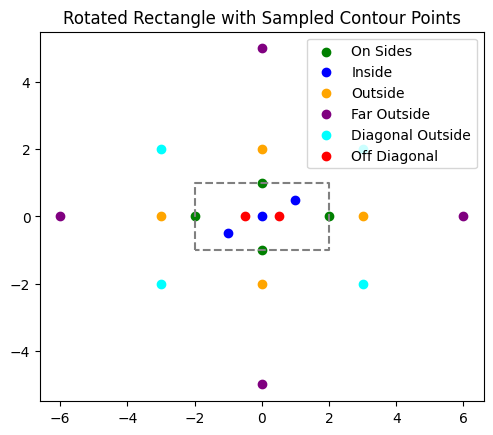

All tests passed!
Step 1: horizontal, shift=1.9999979347611103, used_iters=16
Step 2: vertical, shift=0.5000000088678954, used_iters=7


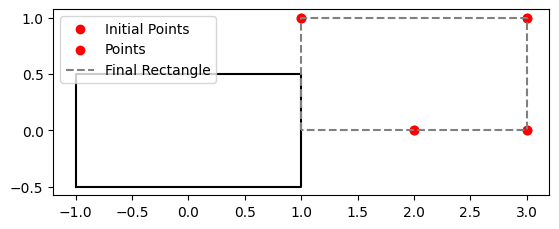


[check] encode_state invariants
Encoded state: (2, 0, 2, 0, 4, 0, 0)
 sides    (T,B,R,L):  2  0  2  0
 distances (touch,close,far):  4  0  0
  sum sides == N: True   sum bins == N: True

[check] axis isolation via apply_action()
  vertical: x unchanged? True | y changed? False
  horizontal: y unchanged? True | x changed? False

[run] short rollout using env.step()
 t        action  used   mean_before   mean_after    imprv     reward
------------------------------------------------------------------------
 0  ('horizontal', 6)     6      1.390388     0.389348   1.0010    -0.1990
      expected: 0.4010  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
 1  ('vertical', 4)     4      0.389348     0.030989   0.3584     9.5584
      expected: -0.0416  (set compute_reward(alpha=1,beta=0.1) to match)
      invariants: sides_sum==N? True | bins_sum==N? True
  -> done (terminal reached by touching-all or max_steps)

[check] terminal condit

In [19]:
if __name__ == "__main__":
    # Run the sanity checks for the Rectangle class
    test_rectangle_distance()
    # Run the sanity checks for the RectangleEnv
    sanity_check_step_optimizer()

    env = build_env()
    env.render()

    # 1) state invariants on reset
    env.reset()
    check_encode_state_invariants(env)

    # 2) axis isolation (uses apply_action only)
    check_axis_isolation(env)

    # 3) rollout that prints distances, rewards, and invariants
    rollout_and_print(env, steps=20)

    # 4) terminal checks
    check_terminal_conditions(env)

    print("\n[done] If something looks off (e.g., reward != expected), tweak compute_reward or the alpha/beta used.")

In [ ]:
params = {
    'episodes': 500,
    'alpha': 0.1,
    'gamma': 1,
    'eps_start': 0.2,
    'eps_end': 0.01,
    'eps_decay': 0.9995,
    'seed': 0
}
rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=np.pi/6)
optimizer_params = dict(loss="soft_l1", bounds=(-5, 5))

In [ ]:

rect_params = dict(center=(0, 0), width=2.0, height=1.0, theta=np.pi / 6)
optimizer_params = dict(loss="soft_l1", bounds=(-5, 5))

R = Rectangle(**rect_params)
x_lim = [-10, 10]
y_lim = [-10, 10]
points_params = dict(
    num_points=15,
    offset=(1, 1),
    rotation=np.pi / 6,
    jitter_t=0.05,
    jitter_n=0.01,
    rng=np.random.default_rng(42),
)

In [15]:
# check the generator and rendering
offset_range = ((-5, 5), (-5, 5))
env_generator = make_env_generator(
    rect_params, optimizer_params, points_params,
    offset_range=offset_range,
    rotation_range=(-np.pi/2, np.pi/2),
    x_lim=(-10, 10),
    y_lim=(-10, 10),
    rng=np.random.default_rng(0)
)
nA = len(env_generator().actions)
# # generate and render 5 samples
# for i in range(5):
#     env = env_generator()
#     print(f"Env {i}: offset={env.rect_params['center']}, theta={env.rect_params['theta']:.2f}")
#     env.render(show=True)

Using x_lim=(-10, 10), y_lim=(-10, 10) to accommodate offsets/rotations.


In [ ]:
s_agent = SarsaAgent(nA=nA)
q_agent = QLearningAgent(nA=nA)
s1_agent = NStepSarsaAgent(nA=nA, n_step=1)
s2_agent = NStepSarsaAgent(nA=nA, n_step=2)
s3_agent = NStepSarsaAgent(nA=nA, n_step=3)
q1_agent = NStepQLearningAgent(nA=nA, n_step=1)
q2_agent = NStepQLearningAgent(nA=nA, n_step=2)
q3_agent = NStepQLearningAgent(nA=nA, n_step=3)
trainer = Trainer(envs=env_generator, agent=s1_agent, reuse_per_env=5)
trainer.fit(episodes=5000)

In [ ]:
env = env_generator()
metrices = trainer.evaluate(env, episodes=1)
# display(env.log)
display(metrices)
env.show_gif()

[{'original_dist': np.float64(3.6334436045302057),
  'ep': 0,
  'reward': np.float64(10.786697576158844),
  'steps': 4,
  'optimizer_iters': 19}]

In [436]:
# trainer.plot_training_logs(
#     smooth_window=100,
#     ylim=(-29, 14),
#     )

In [437]:
# trainer.plot_training_logs(
#     col_name = "steps", 
#     smooth_window=100,
#     )

In [14]:
# trainer.plot_training_logs(
#     smooth_window=100, 
#     col_name="n_iters", 
#     ylim=(None, 205),
#     )

In [ ]:

res_s = []
for n in [1, 2, 3]:
    n_agent = NStepSarsaAgent(nA=nA, n_step=n)
    trainer = Trainer(envs=env_generator, agent=n_agent, reuse_per_env=5)
    trainer.fit(episodes=3000)

    # --- training plots ---
    trainer.plot_training_logs(smooth_window=50, ylim=(-29, 14), col_name="reward")
    plt.savefig(f"s_train_rewards_n{n}.png")
    plt.close()

    trainer.plot_training_logs(col_name="steps", smooth_window=100)
    plt.savefig(f"s_train_steps_n{n}.png")
    plt.close()

    trainer.plot_training_logs(col_name="n_iters", smooth_window=100, ylim=(None, 205))
    plt.savefig(f"s_train_niters_n{n}.png")
    plt.close()

    # --- evaluation ---
    all_metrics = []
    for _ in range(10):
        metrics = trainer.evaluate(env_generator(), episodes=5)
        all_metrics.extend(metrics)

    for m in all_metrics:
        m["n_step"] = n
    res_s.extend(all_metrics)

    print(f"Completed n-step Sarsa-learning with n={n}")

# ---- evaluation results: boxplots ----

df_all = pd.DataFrame(res_s)

plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="n_step", y="reward")
plt.title("Reward distribution across n-step Sarsa")
plt.savefig("sarsa_eval_rewards.png")
plt.close()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="n_step", y="steps")
plt.title("Action steps across n-step Q-learning")
plt.savefig("sarsa_eval_steps.png")
plt.close()


plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="n_step", y="optimizer_iters")
plt.title("Optimizer iterations across n-step Sarsa")
plt.savefig("sarsa_eval_boxplot_iters.png")
plt.close()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

res_q = []
for n in [1, 2, 3]:
    n_agent = NStepQLearningAgent(nA=nA, n_step=n)
    trainer = Trainer(envs=env_generator, agent=n_agent, reuse_per_env=5)
    trainer.fit(episodes=3000)

    # --- training plots ---
    trainer.plot_training_logs(smooth_window=50, ylim=(-29, 14), col_name="reward")
    plt.savefig(f"q_train_rewards_n{n}.png")
    plt.close()

    trainer.plot_training_logs(col_name="steps", smooth_window=100)
    plt.savefig(f"q_train_steps_n{n}.png")
    plt.close()

    trainer.plot_training_logs(col_name="n_iters", smooth_window=100, ylim=(None, 205))
    plt.savefig(f"q_train_niters_n{n}.png")
    plt.close()

    # --- evaluation ---
    all_metrics = []
    for _ in range(10):
        metrics = trainer.evaluate(env_generator(), episodes=5)
        all_metrics.extend(metrics)

    for m in all_metrics:
        m["n_step"] = n
    res_q.extend(all_metrics)

    print(f"Completed n-step Q-learning with n={n}")
    
df_all = pd.DataFrame(res_q)

plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="n_step", y="reward")
plt.title("Reward distribution across n-step Q-learning")
plt.savefig("q_eval_rewards.png")
plt.close()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="n_step", y="steps")
plt.title("Action steps across n-step Q-learning")
plt.savefig("q_eval_steps.png")
plt.close()

plt.figure(figsize=(8,5))
sns.boxplot(data=df_all, x="n_step", y="optimizer_iters")
plt.title("Optimizer iterations across n-step Q-learning")
plt.savefig("q_eval_iters.png")
plt.close()

Completed n-step Q-learning with n=1
Completed n-step Q-learning with n=2
Completed n-step Q-learning with n=3
